<a href="https://colab.research.google.com/github/prathamsss/Rippled-Fruit-Classification-Detection/blob/main/Fruit_Quality_classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
import os
p="/content/drive/MyDrive/ML/fruit_quality/classification/Fresh_Apple"
pp="/content/dataset/train/rottenapples"
len(os.listdir(p)),len(os.listdir(pp))

(2088, 2342)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#import torch.utils.data as data
#from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
%matplotlib inline
#mounting google drive to access the dataset from drive folder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen
plt.ion()

In [2]:
data_dir = "/content/drive/MyDrive/ML/fruit_quality/classification/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

#Spilting into 75-25%

def train_val_dataset(dataset, val_split=0.30):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder(data_dir, transform=Compose([Resize((224,224)),ToTensor()]))
print("All Data Count(100%) =>",len(dataset))
datasets = train_val_dataset(dataset)
print("Train (75%) => ",len(datasets['train']))
print("Test (25%). => ",len(datasets['val']))
# The original dataset is available in the Subset class
dataset_sizes = {'train':3514,'val':1506}
classes = dataset.classes


All Data Count(100%) => 5020
Train (75%) =>  3514
Test (25%). =>  1506


torch.Size([4, 3, 224, 224]) torch.Size([4])


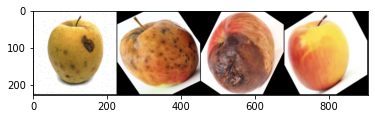

Rotten_Apple Rotten_Apple Rotten_Apple Fresh_Apple


In [7]:
# Visualize 
def imshow(img):
    img = img     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataloaders = {x:DataLoader(datasets[x],4, shuffle=True, num_workers=4) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)
imshow(torchvision.utils.make_grid(x))
print(' '.join('%5s' % dataset.classes[y[j]] for j in range(4)))  #Labels    

In [10]:
loss_train=[]
epo=[]
loss_val=[]
acc_train=[]
acc_val=[]
v_epo=[]
from copy import deepcopy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            


            if phase=='train':
              loss_train.append(epoch_loss)
              epo.append(epoch)
              acc_train.append(epoch_acc)

            if phase=='val':
              loss_val.append(epoch_loss)
              v_epo.append(epoch)
              acc_val.append(epoch_acc)  
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

            

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
from matplotlib.pyplot import figure

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figsize=(40,80)
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
from torch.utils.tensorboard import SummaryWriter

model_nm= 'resnet18'
learning_rate =0.002 
momentum=0.7
no_classes= 2

model_conv = torchvision.models.resnet18(pretrained=True)  # load pretrained model
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, no_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=momentum)
optimizer_conv = optim.Adam(model_conv.fc.parameters(),lr=learning_rate)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=7)

Epoch 0/6
----------
train Loss: 0.4136 Acc: 0.8321
val Loss: 0.0807 Acc: 0.9774

Epoch 1/6
----------
train Loss: 0.3484 Acc: 0.8668
val Loss: 0.1291 Acc: 0.9555

Epoch 2/6
----------
train Loss: 0.3196 Acc: 0.8765
val Loss: 0.0577 Acc: 0.9788

Epoch 3/6
----------
train Loss: 0.3073 Acc: 0.8828
val Loss: 0.0592 Acc: 0.9781

Epoch 4/6
----------
train Loss: 0.3449 Acc: 0.8725
val Loss: 0.0653 Acc: 0.9788

Epoch 5/6
----------
train Loss: 0.3906 Acc: 0.8628
val Loss: 0.0906 Acc: 0.9695

Epoch 6/6
----------
train Loss: 0.3282 Acc: 0.8765
val Loss: 0.0499 Acc: 0.9834

Training complete in 3m 26s
Best val Acc: 0.983400


train =  [0.4135679977741379, 0.34842367559802195, 0.31957066744333, 0.30729494237678373, 0.34490226108925237, 0.3906210750278073, 0.32815211439890113] [0, 1, 2, 3, 4, 5, 6] [tensor(0.8321, device='cuda:0', dtype=torch.float64), tensor(0.8668, device='cuda:0', dtype=torch.float64), tensor(0.8765, device='cuda:0', dtype=torch.float64), tensor(0.8828, device='cuda:0', dtype=torch.float64), tensor(0.8725, device='cuda:0', dtype=torch.float64), tensor(0.8628, device='cuda:0', dtype=torch.float64), tensor(0.8765, device='cuda:0', dtype=torch.float64)] 
val=  [0.08072466726008565, 0.12906585010696023, 0.057653774380029006, 0.05921635428298766, 0.06531601667545327, 0.0906183790228998, 0.049869529209781695] [0, 1, 2, 3, 4, 5, 6] [tensor(0.9774, device='cuda:0', dtype=torch.float64), tensor(0.9555, device='cuda:0', dtype=torch.float64), tensor(0.9788, device='cuda:0', dtype=torch.float64), tensor(0.9781, device='cuda:0', dtype=torch.float64), tensor(0.9788, device='cuda:0', dtype=torch.float64)

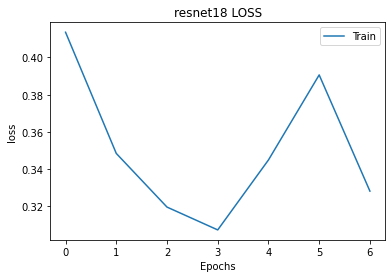

In [14]:
print('train = ',loss_train, epo, acc_train,'\nval= ',loss_val, v_epo, acc_val)
import matplotlib.image as mpimg

torch.save(model_conv, "/content/model.pth")
plt.plot(epo,loss_train,label='Train') 
# plt.plot(loss_val, v_epo, label = 'Validation')   

plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title(model_nm+" LOSS")

plt.legend()
plt.savefig("/content/Torch_Resnet18.jpg",bbox_inches='tight')

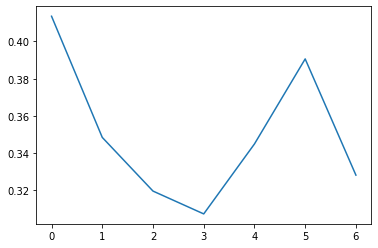

In [15]:
plt.plot(loss_train,label='Train') 

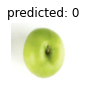

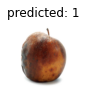

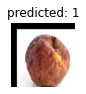

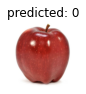

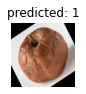

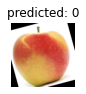

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[602   8]
 [ 17 879]]
[98.68852459 98.10267857]


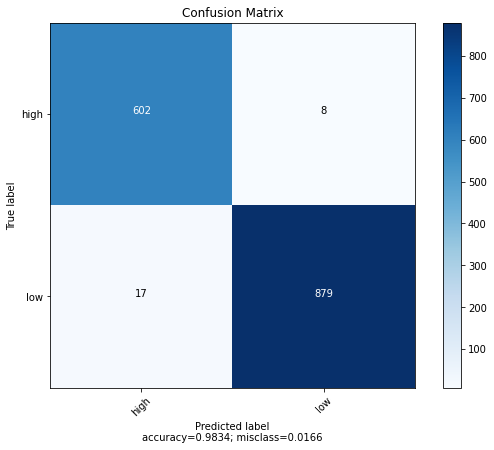

In [28]:
plot_confusion_matrix(cm = conf_mat, 
                      normalize    = False,
                      target_names = ['high', 'low'],
                      title        = "Confusion Matrix")



In [170]:
!wget https://img.pngio.com/natural-foodsapplefruitfoodaccessory-fruitplantmcintosh-accessory-fruit-png-300_320.png

--2021-01-08 16:59:48--  https://img.pngio.com/natural-foodsapplefruitfoodaccessory-fruitplantmcintosh-accessory-fruit-png-300_320.png
Resolving img.pngio.com (img.pngio.com)... 104.27.156.141, 104.27.157.141, 172.67.190.153, ...
Connecting to img.pngio.com (img.pngio.com)|104.27.156.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187592 (183K) [image/png]
Saving to: ‘natural-foodsapplefruitfoodaccessory-fruitplantmcintosh-accessory-fruit-png-300_320.png.1’

natural-foodsapplef 100%[===================>] 183.20K  --.-KB/s    in 0.02s   

2021-01-08 16:59:48 (10.4 MB/s) - ‘natural-foodsapplefruitfoodaccessory-fruitplantmcintosh-accessory-fruit-png-300_320.png.1’ saved [187592/187592]



In [105]:
img ="/content/drive/MyDrive/ML/fruit_quality/classification/testing images/image.jpeg"

In [139]:
from numpy import asarray
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
from pathlib import Path

def predict(img):
  img = os.path.join(img)
  cv_img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
 
  cv2_imshow(cv_img)

  image = Image.open(img)

  npimage =  asarray(image)

  image=Image.fromarray(npimage)
  loader = transforms.Compose([transforms.Resize(255),
                              transforms.CenterCrop(224),
                              transforms.ToTensor()])

  # image = Image.open(self.img)   
  image = loader(image).float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  image_pred  =   image.to(device)
  model = torch.load("/content/drive/MyDrive/ML/fruit_quality/classification/model.pth")
  out = model(image_pred)
  _, preds = torch.max(out, 1)
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  predlist=torch.cat([predlist,preds.view(-1).cpu()])
  prediction = str(predlist)
  prediction
  if prediction == 'tensor([1])':
    final_prediction = "Rippled Apple"


  elif prediction == 'tensor([0])':
    final_prediction = "Good Apple " 
     
  return final_prediction

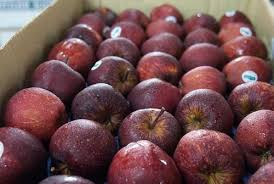

Good Apple 


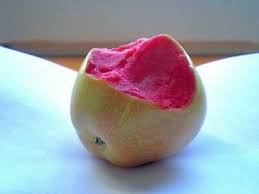

Rippled Apple


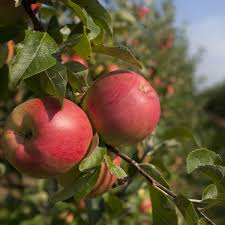

Good Apple 


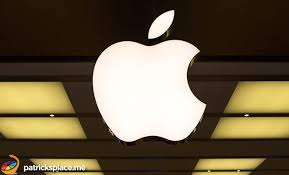

Good Apple 


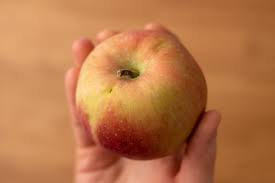

Rippled Apple


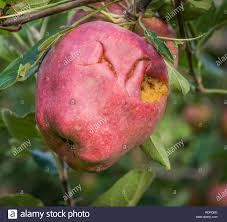

Rippled Apple


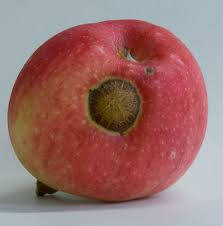

Rippled Apple


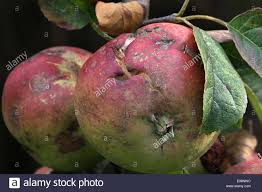

Rippled Apple


In [140]:
test_set = "/content/drive/MyDrive/ML/fruit_quality/classification/testing images/"
for i in os.listdir(test_set):
  
  if i.endswith('.ipynb_checkpoints'):
    pass
  else:
    
    print(predict(os.path.join(test_set ,i)))
